# 이상 탐지 프로젝트
## 0. 데이터 준비

In [53]:
#!pip install optuna
#!pip install catboost

In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import LabelEncoder

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.utils.class_weight import compute_class_weight
import scipy.cluster.hierarchy as sch

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [3]:
# 설정을 변경하여 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

display(train_data,test_data)

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Z Unit Time_Dam,CURE END POSITION Z Judge Value_Dam,CURE END POSITION Θ Collect Result_Dam,CURE END POSITION Θ Unit Time_Dam,CURE END POSITION Θ Judge Value_Dam,CURE SPEED Collect Result_Dam,CURE SPEED Unit Time_Dam,CURE SPEED Judge Value_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION X Unit Time_Dam,CURE STANDBY POSITION X Judge Value_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Z Unit Time_Dam,CURE STANDBY POSITION Z Judge Value_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE STANDBY POSITION Θ Unit Time_Dam,CURE STANDBY POSITION Θ Judge Value_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION X Unit Time_Dam,CURE START POSITION X Judge Value_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Z Unit Time_Dam,CURE START POSITION Z Judge Value_Dam,CURE START POSITION Θ Collect Result_Dam,CURE START POSITION Θ Unit Time_Dam,CURE START POSITION Θ Judge Value_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED SPEED OF RESIN Unit Time_Dam,DISCHARGED SPEED OF RESIN Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage2) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage3) Judge Value_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage1) Unit Time_Dam,Dispense Volume(Stage1) Judge Value_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage2) Unit Time_Dam,Dispense Volume(Stage2) Judge Value_Dam,Dispense Volume(Stage3) Collect Result_Dam,Dispense Volume(Stage3) Unit Time_Dam,Dispense Volume(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position X Unit Time_Dam,HEAD Standby Position X Judge Value_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Y Unit Time_Dam,HEAD Standby Position Y Judge Value_Dam,HEAD Standby Position Z Collect Result_Dam,HEAD Standby Position Z Unit Time_Dam,HEAD Standby Position Z Judge Value_Dam,Head

,Set ID,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Z Unit Time_Dam,CURE END POSITION Z Judge Value_Dam,CURE END POSITION Θ Collect Result_Dam,CURE END POSITION Θ Unit Time_Dam,CURE END POSITION Θ Judge Value_Dam,CURE SPEED Collect Result_Dam,CURE SPEED Unit Time_Dam,CURE SPEED Judge Value_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION X Unit Time_Dam,CURE STANDBY POSITION X Judge Value_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Z Unit Time_Dam,CURE STANDBY POSITION Z Judge Value_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE STANDBY POSITION Θ Unit Time_Dam,CURE STANDBY POSITION Θ Judge Value_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION X Unit Time_Dam,CURE START POSITION X Judge Value_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Z Unit Time_Dam,CURE START POSITION Z Judge Value_Dam,CURE START POSITION Θ Collect Result_Dam,CURE START POSITION Θ Unit Time_Dam,CURE START POSITION Θ Judge Value_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED SPEED OF RESIN Unit Time_Dam,DISCHARGED SPEED OF RESIN Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage2) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage3) Judge Value_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage1) Unit Time_Dam,Dispense Volume(Stage1) Judge Value_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage2) Unit Time_Dam,Dispense Volume(Stage2) Judge Value_Dam,Dispense Volume(Stage3) Collect Result_Dam,Dispense Volume(Stage3) Unit Time_Dam,Dispense Volume(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position X Unit Time_Dam,HEAD Standby Position X Judge Value_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Y Unit Time_Dam,HEAD Standby Position Y Judge Value_Dam,HEAD Standby Position Z Collect Result_Dam,HEAD Standby Position Z Unit Time_Dam,HEAD Standby Position Z Judge Value_D

## 2. 데이터 전처리

In [4]:
def preprocess_data(df):
    # 데이터 오류 수정
    ## 'OK' 값을 결측치로 변환할 열들
    columns_to_replace = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    ]
    ## 각 열에 대해 'OK' 값을 결측치로 변환
    df[columns_to_replace] = df[columns_to_replace].replace('OK', pd.NA)
    ## 수치형으로 변환
    df[columns_to_replace] = df[columns_to_replace].apply(pd.to_numeric)
    
    
    # 결측치 처리
    ## 모든 행이 다 결측치인 열을 제거
    df = df.loc[:, ~df.isnull().all()]
    
    ## is_null 파생변수 생성
    ###결측치라면 1, 아니면 0
    df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int) 
    
    ## 각 열의 결측치 개수를 계산
    missing_values = df.isnull().sum()
    
    ## 결측치가 있는 열들만 필터링
    missing_columns = missing_values[missing_values > 0]
    
    ## 결측치가 있는 칼럼을 제외한 새로운 데이터프레임 생성
    columns_to_drop = missing_columns.index
    df = df.drop(columns=columns_to_drop)
    
    ## 결측치 없고, 유니크한 값 1개 피처 찾아서 제거
    train_na_columns = [col for col in df.columns if df[col].isna().sum() == 0 and df[col].nunique() == 1]
    df = df.drop(columns=train_na_columns)
    
    
    # 컬럼 통일 및 제거
    ## WorkMode 데이터에서 Fill 1과 Fill 2가 유사해서 조정 후 하나 드랍
    df['WorkMode Collect Result_Dam'] = df['WorkMode Collect Result_Dam'].replace(7, np.nan).astype(object)
    df['WorkMode Collect Result_Fill2'] = df['WorkMode Collect Result_Fill2'].replace(0, 7).astype(object)
    df.drop(columns=['WorkMode Collect Result_Fill1'], inplace=True)
    
    ## 총 시간 변수 생성 및 개별 변수 제거
    df['Total time'] = (df['Machine Tact time Collect Result_Dam'] +
                        df['Machine Tact time Collect Result_Fill1'] +
                        df['Machine Tact time Collect Result_Fill2'])
    df.drop(columns=['Machine Tact time Collect Result_Dam', 
                     'Machine Tact time Collect Result_Fill1', 
                     'Machine Tact time Collect Result_Fill2'], inplace=True)
    
    # 두께 데이터 (일단) drop & 동일 칼럼 제거
    df.drop(columns=['THICKNESS 1 Collect Result_Dam', 
                     'THICKNESS 2 Collect Result_Dam', 
                     'THICKNESS 3 Collect Result_Dam',
                    'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
                     'Stage2 Circle3 Distance Speed Collect Result_Dam', 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
                     'Stage3 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam',
                     'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage2 Line3 Distance Speed Collect Result_Dam', 
                     'Stage3 Line3 Distance Speed Collect Result_Dam','Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2',
                     'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2',], inplace=True)
    
    
    # 장비 관련 파생변수 
    ## 'equipment'가 들어가는 칼럼을 찾기
    #equipment_columns = [col for col in df.columns if 'Equipment' in col]
    
    ## 각 'equipment' 열에 대해 마지막 숫자를 기준으로 라벨 인코딩 수행
    #for col in equipment_columns:
        # 마지막 숫자를 추출
        #df[col + '_last_digit'] = df[col].str.extract(r'(\d)$')
        # _last_digit 칼럼을 숫자형으로 변환
        #df[col + '_last_digit'] = df[col + '_last_digit'].astype(float)
    
    ## 'Equipment'가 들어가는 칼럼 drop
    #df = df.drop(columns=equipment_columns)
    
    # Chamber Temp. Judge Value_AutoClave 칼럼 값 변환
    df['Chamber Temp. Judge Value_AutoClave'] = df['Chamber Temp. Judge Value_AutoClave'].apply(lambda x: 1 if x == 'OK' else 0)

    return df

### 파생변수 추가

In [5]:
def filter_coordinate_columns(df):
    # 좌표 데이터들만 필터링
    coordinate_columns = df.filter(regex='X|Y|Z').columns
    coordinate_data = df[coordinate_columns]

    # 결측치가 있는 행 제거
    coordinate_data_clean = coordinate_data.dropna()

    # 결측치 제거 후 상관계수 행렬 계산
    correlation_matrix_clean = coordinate_data_clean.corr()

    # 상관계수 절대값이 1인 경우 필터링 (자기 자신과의 상관관계 제외)
    threshold = 1
    high_correlation_pairs = correlation_matrix_clean[
        (correlation_matrix_clean.abs() >= threshold) & (correlation_matrix_clean.abs() < 1)
    ]

    # 상관계수가 1인 변수 쌍 확인 및 저장
    high_corr_columns = set()  # 상관관계가 1인 칼럼들을 저장할 집합
    for i in range(len(correlation_matrix_clean.columns)):
        for j in range(i+1, len(correlation_matrix_clean.columns)):
            if abs(correlation_matrix_clean.iloc[i, j]) >= threshold:
                col1 = correlation_matrix_clean.columns[i]
                col2 = correlation_matrix_clean.columns[j]
                high_corr_columns.update([col1, col2])

    # 상관관계가 높은 칼럼들을 저장할 딕셔너리 초기화
    correlation_groups = defaultdict(set)

    # 상관계수가 threshold 이상인 변수 쌍을 그룹화
    for i in range(len(high_correlation_pairs)):
        for j in range(i+1, len(high_correlation_pairs.columns)):
            if abs(correlation_matrix_clean.iloc[i, j]) >= threshold:
                col1 = correlation_matrix_clean.columns[i]
                col2 = correlation_matrix_clean.columns[j]
                # 그룹화된 변수들을 같은 그룹에 추가
                for group in correlation_groups.values():
                    if col1 in group or col2 in group:
                        group.update([col1, col2])
                        break
                else:
                    # 새로운 그룹 생성
                    correlation_groups[len(correlation_groups)] = {col1, col2}

    # correlation_groups에 포함된 모든 칼럼들 집합으로 수집
    excluded_columns = set()
    for group in correlation_groups.values():
        excluded_columns.update(group)

    # 제외된 좌표 칼럼들만 필터링
    filtered_coordinate_data = coordinate_data.drop(columns=excluded_columns, errors='ignore')

    # PCA에 사용할 칼럼명 추출
    filtered_coordinate_cols = filtered_coordinate_data.columns

    return filtered_coordinate_cols, correlation_groups

In [6]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

/tmp/ipykernel_105/384458707.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int)
/tmp/ipykernel_105/384458707.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_null'] = df['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'].isnull().astype(int)


### train

In [7]:
filtered_cols, corr_groups = filter_coordinate_columns(train_data)

# 결과 확인
print("Filtered Coordinate Columns:")
print(filtered_cols)

Filtered Coordinate Columns:
Index(['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD Standby Position X Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position X Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Re

In [8]:
# corr_groups에 저장된 칼럼들을 하나의 리스트로 담기
all_columns = []
seen_columns = set()

for group in corr_groups.values():
    for col in group:
        if col not in seen_columns:
            all_columns.append(col)
            seen_columns.add(col)

# 결과 확인
print(all_columns)

['CURE START POSITION X Collect Result_Dam', 'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Fill2', 'HEAD Standby Position Y Collect Result_Fill1', 'HEAD Standby Position Y Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Fill2', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position X Collect Result_Fill2', 'Head Clean Position X Collect Result_Fill1', 'Head Purge Position Z Collect Result_Fill2', 'Head Clean Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill2', 'Head Purge Position X Collect Result_Fill2', 'Head Purge Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill1', 'Head Clean Position Z Collect Result_Fill2', 'Head Purge 

In [9]:
def apply_pca(df, filtered_coordinate_cols, n_components, prefix):
    # PCA에 사용할 데이터셋 추출
    pca_input_data = df[filtered_coordinate_cols]

    # PCA 수행
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pca_input_data)

    # PCA 결과를 데이터프레임으로 저장
    pca_df = pd.DataFrame(data=pca_result, columns=[f'{prefix}{i+1}' for i in range(n_components)])

    # PCA에 사용된 좌표 피처 제거
    df = df.drop(columns=filtered_coordinate_cols)

    # PCA 결과 (주성분) 추가
    for i in range(n_components):
        df[f'{prefix}{i+1}'] = pca_df[f'{prefix}{i+1}']

    return df, pca

In [10]:
train_data, pca_result_PC = apply_pca(train_data, filtered_cols, 2, 'PC')
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Zero Position X Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Result_Fill1,Head Purge Position X Collect Result_Fill1,Head Purge Position Y Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,HEAD Standby Position Y Collect Result_Fill2,HEAD Standby Position Z Collect Result_Fill2,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,is_null,Total time,PC1,PC2
0,Dam dispenser #1,AJX75334505,4F1XA938-1,240.0,2.5,-90,100,1030,-90,16,14.9,8.4,14.7,1.04,0.58,1.02,274.51,274.51,257,66,0.0,127.5,257,130.85,58.5,7,127,1,5800,5800,5800,5600,5800,5300,5300,5300,5300,5300,5800,5800,5800,5800,0.0,0.312,240,0.493,1,0.499,120,54,361,1,Fill1 dispenser #1,10.6,12.7,3.6,12.6,12.06,3.42,11.97,289,50,0.0,123

In [11]:
train_data, pca_result_corr_PC = apply_pca(train_data, all_columns, 2,  prefix='corr_PC')
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2
0,Dam dispenser #1,AJX75334505,4F1XA938-1,-90,100,-90,16,14.9,8.4,14.7,1.04,0.58,1.02,58.5,7,127,1,5800,5800,5800,5600,5800,5300,5300,5300,5300,5300,5800,5800,5800,5800,0.0,0.312,240,0.493,1,0.499,120,54,361,1,Fill1 dispenser #1,10.6,12.7,3.6,12.6,12.06,3.42,11.97,55.7,7,127,Fill2 dispenser #1,48,19.9,7,127,1,Normal,1,507.612,-972.400533,-421.477040,-280.620128,-426.600990
1,Dam dispenser #1,AJX75334505,3KPM0016-2,-90,70,-90,10,21.3,4.9,21.3,1.49,0.34,1.49,7.0,185,1,4000,4000,4000,4000,4000,9000,9000,9000,9000,9000,4000,4000,4000,4000,4000,NaN,0.311,241,0.311,121,0.498,121,54,483,1,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,7.0,185,1,Fill2 dispenser #1,50,7.0,185,1,7,Normal,1,141.200,-1078.316704,235.097171,-535.453983,285.363290
2,Dam dispenser #2,AJX75334501,4E1X9167-1,90,85,90,16,14.7,8.5,14.7,1.61,0.93,1.61,76.9,10,73,1,5800,5800,5800,5800,5800,5300,5300,5300,5300,5300,5800,5800,5800,5800,0.003,0.315,241,0.490,1,0.498,121,56,363,1,Fill1 dispenser #2,10.6,13.5,3.5,13.4,12.82,3.32,12.73,58.7,10,73,Fill2 dispenser #2,50,19.8,10,73,1,Normal,0,507.632,1867.544427,-391.724381,724.724291,-66.764489
3,Dam dispenser #2,AJX75334501,3K1X0057-1,90,70,90,10,21.3,8.4,21.3,1.49,0.58,1.49,12.0,268,1,4000,4000,4000,4000,4000,5000,5000,5000,5000,5000,4000,4000,4000,4000,4000,NaN,0.299,241,0.300,121,0.500,121,54,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,12.0,268,1,Fill2 dispenser #2,50,12.0,268,1,7,Normal,1,148.100,1025.058411,1885.692258,469.889604,645.201566
4,Dam dispenser #1,AJX75334501,3HPM0007-1,-90,70,-90,10,9.7,4.9,9.6,0.67,0.34,0.67,8.0,121,1,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,

### test

In [12]:
filtered_cols, corr_groups = filter_coordinate_columns(test_data)

# 결과 확인
print("Filtered Coordinate Columns:")
print(filtered_cols)

Filtered Coordinate Columns:
Index(['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD Standby Position X Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position X Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Re

In [13]:
# corr_groups에 저장된 칼럼들을 하나의 리스트로 담기
all_columns = []
seen_columns = set()

for group in corr_groups.values():
    for col in group:
        if col not in seen_columns:
            all_columns.append(col)
            seen_columns.add(col)

# 결과 확인
print(all_columns)

['CURE START POSITION X Collect Result_Dam', 'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam', 'Head Zero Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Fill2', 'HEAD Standby Position Y Collect Result_Fill1', 'HEAD Standby Position Y Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Fill2', 'HEAD Standby Position Z Collect Result_Dam', 'Head Clean Position X Collect Result_Fill1', 'Head Clean Position X Collect Result_Fill2', 'Head Purge Position Z Collect Result_Fill2', 'Head Clean Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill2', 'Head Purge Position X Collect Result_Fill2', 'Head Purge Position Y Collect Result_Fill1', 'HEAD Standby Position Z Collect Result_Fill1', 'Head Clean Position Z Collect Result_Fill2', 'Head Purge 

In [14]:
def apply_pca(df, filtered_coordinate_cols, n_components, prefix):
    # PCA에 사용할 데이터셋 추출
    pca_input_data = df[filtered_coordinate_cols]

    # PCA 수행
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pca_input_data)

    # PCA 결과를 데이터프레임으로 저장
    pca_df = pd.DataFrame(data=pca_result, columns=[f'{prefix}{i+1}' for i in range(n_components)])

    # PCA에 사용된 좌표 피처 제거
    df = df.drop(columns=filtered_coordinate_cols)

    # PCA 결과 (주성분) 추가
    for i in range(n_components):
        df[f'{prefix}{i+1}'] = pca_df[f'{prefix}{i+1}']

    return df, pca

In [15]:
test_data, pca_result_PC = apply_pca(test_data, filtered_cols, 2, 'PC')
test_data

,Set ID,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Zero Position X Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1,HEAD Standby Position Y Collect Result_Fill1,HEAD Standby Position Z Collect Result_Fill1,Head Clean Position X Collect Result_Fill1,Head Clean Position Y Collect Result_Fill1,Head Clean Position Z Collect Result_Fill1,Head Purge Position X Collect Result_Fill1,Head Purge Position Y Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,CURE START POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,HEAD Standby Position Y Collect Result_Fill2,HEAD Standby Position Z Collect Result_Fill2,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,1000.0,12.5,90,70,280,90,10,17.0,4.9,17.0,1.19,0.34,1.19,282.150,282.150,66,0,127.5,66.0,66,505.00,13.0,195,1,5000,5000,5000,5000,5000,9000,900

In [16]:
test_data, pca_result_corr_PC = apply_pca(test_data, all_columns, 2,  prefix='corr_PC')
test_data

,Set ID,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,90,70,90,10,17.0,4.9,17.0,1.19,0.34,1.19,13.0,195,1,5000,5000,5000,5000,5000,9000,9000,9000,9000,9000,5000,5000,5000,5000,5000,NaN,0.315,241,0.316,121,0.498,121,54,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,13.0,195,1,Fill2 dispenser #2,50,13.0,195,1,7,1,135.70,1027.165268,1886.261305,471.546277,645.505396
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,90,70,90,16,14.2,8.3,14.2,0.99,0.58,0.99,60.5,14,256,1,6000,6000,6000,6000,6000,5500,5500,5500,5500,5500,6000,6000,6000,6000,0.007,0.304,241,0.583,1,0.600,121,56,363,1,Fill1 dispenser #2,10.6,12.9,3.6,12.9,12.25,3.42,12.25,57.4,14,256,Fill2 dispenser #2,50,19.8,14,256,1,0,478.02,1868.624873,-390.738272,724.340330,-67.189948
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,-90,70,-90,10,9.7,4.9,9.7,0.67,0.34,0.67,1.0,98,1,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,9000,NaN,0.308,241,0.308,121,0.500,121,54,483,1,Fill1 dispenser #1,10.6,13.4,3.6,13.3,12.73,3.42,12.63,1.0,98,1,Fill2 dispenser #1,50,1.0,98,1,7,1,198.20,-1075.693573,237.943039,-534.845837,288.587385
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,90,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.2,14,0,1,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,0.0,0.301,241,0.302,90,0.500,121,52,452,1,Fill1 dispenser #2,10.6,13.5,4.0,13.5,12.82,3.80,12.82,68.3,14,0,Fill2 dispenser #2,50,20.0,14,0,1,1,495.00,1829.415024,-399.231093,724.302722,-67.110406
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A

## 2. EDA

### train

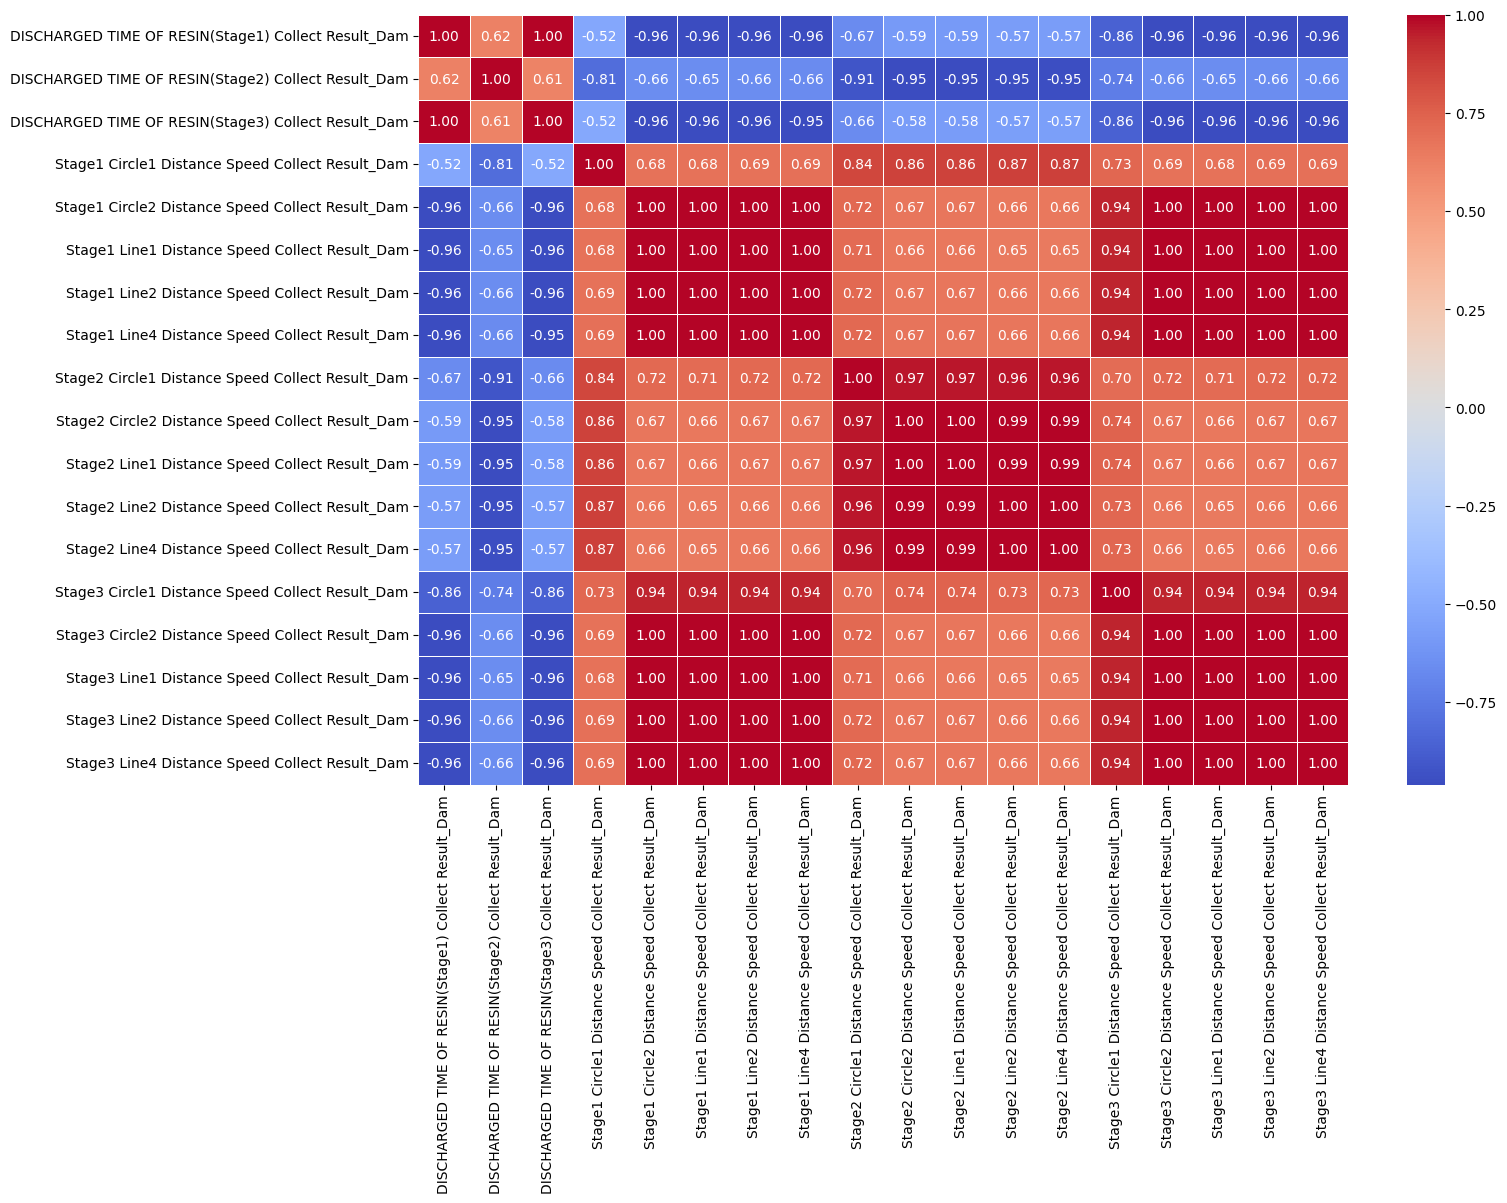

In [17]:
# 관심 있는 두 그룹의 칼럼들을 리스트로 정의
group1_columns = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
]

group2_columns = [
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 두 그룹의 칼럼들을 합쳐서 필터링
selected_columns = group1_columns + group2_columns
selected_data = train_data[selected_columns]

# 상관관계 행렬 계산
correlation_matrix = selected_data.corr()

# 히트맵으로 상관관계 행렬 시각화
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.show()

/tmp/ipykernel_105/3860996432.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(1 - correlation_matrix, method='ward')


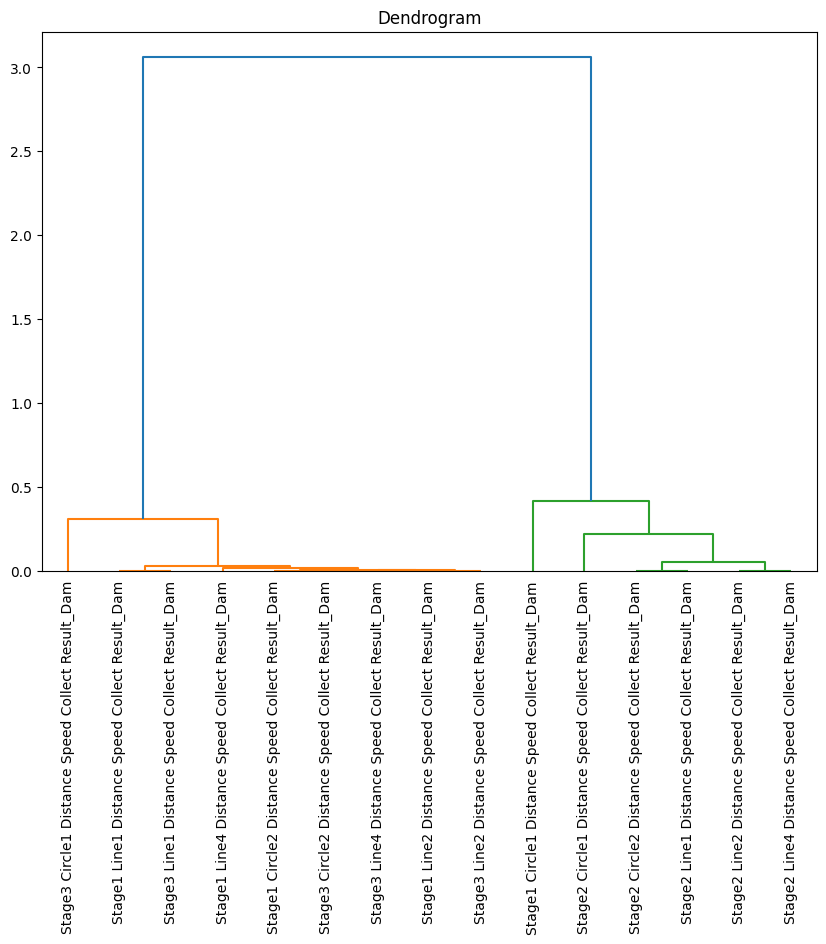

In [18]:
# 예시: 상관계수 행렬 계산
correlation_matrix = train_data[group2_columns].corr().values

# 계층적 클러스터링을 위한 linkage 계산
linkage_matrix = sch.linkage(1 - correlation_matrix, method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix, labels=group2_columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram")
plt.show()

In [19]:
# 임계값에 따라 클러스터를 생성합니다.
threshold = 0.25 
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# 클러스터 결과 출력
clustered_variables = pd.DataFrame({'Variable': group2_columns, 'Cluster': clusters})
print(clustered_variables)

                                            Variable  Cluster
0   Stage1 Circle1 Distance Speed Collect Result_Dam        4
1   Stage1 Circle2 Distance Speed Collect Result_Dam        1
2     Stage1 Line1 Distance Speed Collect Result_Dam        1
3     Stage1 Line2 Distance Speed Collect Result_Dam        1
4     Stage1 Line4 Distance Speed Collect Result_Dam        1
5   Stage2 Circle1 Distance Speed Collect Result_Dam        3
6   Stage2 Circle2 Distance Speed Collect Result_Dam        3
7     Stage2 Line1 Distance Speed Collect Result_Dam        3
8     Stage2 Line2 Distance Speed Collect Result_Dam        3
9     Stage2 Line4 Distance Speed Collect Result_Dam        3
10  Stage3 Circle1 Distance Speed Collect Result_Dam        2
11  Stage3 Circle2 Distance Speed Collect Result_Dam        1
12    Stage3 Line1 Distance Speed Collect Result_Dam        1
13    Stage3 Line2 Distance Speed Collect Result_Dam        1
14    Stage3 Line4 Distance Speed Collect Result_Dam        1


### test

In [20]:
# 두 그룹의 칼럼들을 합쳐서 필터링
selected_columns = group1_columns + group2_columns
selected_data = test_data[selected_columns]

In [21]:
# 임계값에 따라 클러스터를 생성합니다.
threshold = 0.25 
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# 클러스터 결과 출력
clustered_variables = pd.DataFrame({'Variable': group2_columns, 'Cluster': clusters})
print(clustered_variables)

                                            Variable  Cluster
0   Stage1 Circle1 Distance Speed Collect Result_Dam        4
1   Stage1 Circle2 Distance Speed Collect Result_Dam        1
2     Stage1 Line1 Distance Speed Collect Result_Dam        1
3     Stage1 Line2 Distance Speed Collect Result_Dam        1
4     Stage1 Line4 Distance Speed Collect Result_Dam        1
5   Stage2 Circle1 Distance Speed Collect Result_Dam        3
6   Stage2 Circle2 Distance Speed Collect Result_Dam        3
7     Stage2 Line1 Distance Speed Collect Result_Dam        3
8     Stage2 Line2 Distance Speed Collect Result_Dam        3
9     Stage2 Line4 Distance Speed Collect Result_Dam        3
10  Stage3 Circle1 Distance Speed Collect Result_Dam        2
11  Stage3 Circle2 Distance Speed Collect Result_Dam        1
12    Stage3 Line1 Distance Speed Collect Result_Dam        1
13    Stage3 Line2 Distance Speed Collect Result_Dam        1
14    Stage3 Line4 Distance Speed Collect Result_Dam        1


### 파생변수 추가

### train

In [22]:
stage1_and_3 = ['Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam']

In [23]:
stage2 = ['Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam']

In [24]:
train_data, pca_result_stage1_and_3 = apply_pca(train_data, stage1_and_3, 1, prefix='stage1_and_3')
train_data, pca_result_stage2 = apply_pca(train_data, stage2, 1, prefix='stage2_')

In [25]:
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1
0,Dam dispenser #1,AJX75334505,4F1XA938-1,-90,100,-90,16,14.9,8.4,14.7,1.04,0.58,1.02,58.5,7,127,1,5300,0.0,0.312,240,0.493,1,0.499,120,54,361,1,Fill1 dispenser #1,10.6,12.7,3.6,12.6,12.06,3.42,11.97,55.7,7,127,Fill2 dispenser #1,48,19.9,7,127,1,Normal,1,507.612,-972.400533,-421.477040,-280.620128,-426.600990,-1885.012519,-3842.857792
1,Dam dispenser #1,AJX75334505,3KPM0016-2,-90,70,-90,10,21.3,4.9,21.3,1.49,0.34,1.49,7.0,185,1,4000,4000,NaN,0.311,241,0.311,121,0.498,121,54,483,1,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,7.0,185,1,Fill2 dispenser #1,50,7.0,185,1,7,Normal,1,141.200,-1078.316704,235.097171,-535.453983,285.363290,-6905.099266,4216.297732
2,Dam dispenser #2,AJX75334501,4E1X9167-1,90,85,90,16,14.7,8.5,14.7,1.61,0.93,1.61,76.9,10,73,1,5300,0.003,0.315,241,0.490,1,0.498,121,56,363,1,Fill1 dispenser #2,10.6,13.5,3.5,13.4,12.82,3.32,12.73,58.7,10,73,Fill2 dispenser #2,50,19.8,10,73,1,Normal,0,507.632,1867.544427,-391.724381,724.724291,-66.764489,-1813.946440,-3842.857792
3,Dam dispenser #2,AJX75334501,3K1X0057-1,90,70,90,10,21.3,8.4,21.3,1.49,0.58,1.49,12.0,268,1,4000,4000,NaN,0.299,241,0.300,121,0.500,121,54,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,12.0,268,1,Fill2 dispenser #2,50,12.0,268,1,7,Normal,1,148.100,1025.058411,1885.692258,469.889604,645.201566,-6905.099266,-4724.204173
4,Dam dispenser #1,AJX75334501,3HPM0007-1,-90,70,-90,10,9.7,4.9,9.6,0.67,0.34,0.67,8.0,121,1,9000,9000,NaN,0.302,240,0.302,120,0.498,120,47,480,0,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,8.0,121,1,Fill2 dispenser #1,50,8.0,121,1,7,Normal,1,197.900,-1077.276602,231.547724,-535.466243,285.389423,7236.991917,4216.297732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,-90,70,-90,10,17.0,5.0,17.0,1.19,0.35,1.19,1.0,318,1,5000,5000,NaN,0.300,241,0.300,121,0.500,121,54,483,1,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,1.0,318,1,Fill2 dispenser #1,50,1.0,318,1,7,Normal,1,127.700,-1078.316704,235.097171,-535.453983,285.363290,-4076.681029,4216.297732
40502,Dam dispense

### test

In [26]:
test_data, pca_result_stage1_and_3 = apply_pca(test_data, stage1_and_3, 1, prefix='stage1_and_3')
test_data, pca_result_stage2 = apply_pca(test_data, stage2, 1, prefix='stage2_')

In [27]:
test_data

,Set ID,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,90,70,90,10,17.0,4.9,17.0,1.19,0.34,1.19,13.0,195,1,5000,5000,NaN,0.315,241,0.316,121,0.498,121,54,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,13.0,195,1,Fill2 dispenser #2,50,13.0,195,1,7,1,135.70,1027.165268,1886.261305,471.546277,645.505396,-4118.055769,4167.747974
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,90,70,90,16,14.2,8.3,14.2,0.99,0.58,0.99,60.5,14,256,1,5500,0.007,0.304,241,0.583,1,0.600,121,56,363,1,Fill1 dispenser #2,10.6,12.9,3.6,12.9,12.25,3.42,12.25,57.4,14,256,Fill2 dispenser #2,50,19.8,14,256,1,0,478.02,1868.624873,-390.738272,724.340330,-67.189948,-1289.644341,-3444.386031
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,-90,70,-90,10,9.7,4.9,9.7,0.67,0.34,0.67,1.0,98,1,9000,9000,NaN,0.308,241,0.308,121,0.500,121,54,483,1,Fill1 dispenser #1,10.6,13.4,3.6,13.3,12.73,3.42,12.63,1.0,98,1,Fill2 dispenser #1,50,1.0,98,1,7,1,198.20,-1075.693573,237.943039,-534.845837,288.587385,7195.589945,4167.747974
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,90,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.2,14,0,1,4000,0.0,0.301,241,0.302,90,0.500,121,52,452,1,Fill1 dispenser #2,10.6,13.5,4.0,13.5,12.82,3.80,12.82,68.3,14,0,Fill2 dispenser #2,50,20.0,14,0,1,1,495.00,1829.415024,-399.231093,724.302722,-67.110406,-6946.467198,-7007.872601
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A1XA639-1,-90,70,-90,16,13.2,7.5,13.2,0.92,0.52,0.92,54.3,1,215,1,6500,0.0,0.302,241,0.492,1,0.497,121,54,363,1,Fill1 dispenser #1,10.6,12.9,3.6,12.9,12.25,3.42,12.25,54.3,1,215,Fill2 dispenser #1,50,19.8,1,215,1,0,478.02,-977.210772,-418.160749,-282.063681,-424.074968,124.561374,-2332.828885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,AJX75334501,3K1XB597-1,90,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.0,14,131,1,4000,0.0,0.307,241,0.308,121,0.497,121,50,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,72.9

### 'CURE END POSITION Θ Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam' 하나 drop
* 두 변수 값이 동일해서 하나 drop

In [28]:
# 'CURE END POSITION Θ Collect Result_Dam' 변수를 제거하고 'CURE START POSITION Θ Collect Result_Dam'만 사용
train_data = train_data.drop(columns=['CURE END POSITION Θ Collect Result_Dam'])
test_data = test_data.drop(columns=['CURE END POSITION Θ Collect Result_Dam'])

In [29]:
display(train_data,test_data)

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1
0,Dam dispenser #1,AJX75334505,4F1XA938-1,100,-90,16,14.9,8.4,14.7,1.04,0.58,1.02,58.5,7,127,1,5300,0.0,0.312,240,0.493,1,0.499,120,54,361,1,Fill1 dispenser #1,10.6,12.7,3.6,12.6,12.06,3.42,11.97,55.7,7,127,Fill2 dispenser #1,48,19.9,7,127,1,Normal,1,507.612,-972.400533,-421.477040,-280.620128,-426.600990,-1885.012519,-3842.857792
1,Dam dispenser #1,AJX75334505,3KPM0016-2,70,-90,10,21.3,4.9,21.3,1.49,0.34,1.49,7.0,185,1,4000,4000,NaN,0.311,241,0.311,121,0.498,121,54,483,1,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,7.0,185,1,Fill2 dispenser #1,50,7.0,185,1,7,Normal,1,141.200,-1078.316704,235.097171,-535.453983,285.363290,-6905.099266,4216.297732
2,Dam dispenser #2,AJX75334501,4E1X9167-1,85,90,16,14.7,8.5,14.7,1.61,0.93,1.61,76.9,10,73,1,5300,0.003,0.315,241,0.490,1,0.498,121,56,363,1,Fill1 dispenser #2,10.6,13.5,3.5,13.4,12.82,3.32,12.73,58.7,10,73,Fill2 dispenser #2,50,19.8,10,73,1,Normal,0,507.632,1867.544427,-391.724381,724.724291,-66.764489,-1813.946440,-3842.857792
3,Dam dispenser #2,AJX75334501,3K1X0057-1,70,90,10,21.3,8.4,21.3,1.49,0.58,1.49,12.0,268,1,4000,4000,NaN,0.299,241,0.300,121,0.500,121,54,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,12.0,268,1,Fill2 dispenser #2,50,12.0,268,1,7,Normal,1,148.100,1025.058411,1885.692258,469.889604,645.201566,-6905.099266,-4724.204173
4,Dam dispenser #1,AJX75334501,3HPM0007-1,70,-90,10,9.7,4.9,9.6,0.67,0.34,0.67,8.0,121,1,9000,9000,NaN,0.302,240,0.302,120,0.498,120,47,480,0,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,8.0,121,1,Fill2 dispenser #1,50,8.0,121,1,7,Normal,1,197.900,-1077.276602,231.547724,-535.466243,285.389423,7236.991917,4216.297732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,70,-90,10,17.0,5.0,17.0,1.19,0.35,1.19,1.0,318,1,5000,5000,NaN,0.300,241,0.300,121,0.500,121,54,483,1,Fill1 dispenser #1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,1.0,318,1,Fill2 dispenser #1,50,1.0,318,1,7,Normal,1,127.700,-1078.316704,235.097171,-535.453983,285.363290,-4076.681029,4216.297732
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,100,90,16,14.9,8.5,14.7,1.04,0.59,1.0

,Set ID,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,Equipment_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,Equipment_Fill2,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1
0,0001be084fbc4aaa9d921f39e595961b,Dam dispenser #2,AJX75334501,3J1XF767-1,70,90,10,17.0,4.9,17.0,1.19,0.34,1.19,13.0,195,1,5000,5000,NaN,0.315,241,0.316,121,0.498,121,54,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,13.0,195,1,Fill2 dispenser #2,50,13.0,195,1,7,1,135.70,1027.165268,1886.261305,471.546277,645.505396,-4118.055769,4167.747974
1,0005bbd180064abd99e63f9ed3e1ac80,Dam dispenser #2,AJX75334501,4B1XD472-2,70,90,16,14.2,8.3,14.2,0.99,0.58,0.99,60.5,14,256,1,5500,0.007,0.304,241,0.583,1,0.600,121,56,363,1,Fill1 dispenser #2,10.6,12.9,3.6,12.9,12.25,3.42,12.25,57.4,14,256,Fill2 dispenser #2,50,19.8,14,256,1,0,478.02,1868.624873,-390.738272,724.340330,-67.189948,-1289.644341,-3444.386031
2,000948934c4140d883d670adcb609584,Dam dispenser #1,AJX75334501,3H1XE355-1,70,-90,10,9.7,4.9,9.7,0.67,0.34,0.67,1.0,98,1,9000,9000,NaN,0.308,241,0.308,121,0.500,121,54,483,1,Fill1 dispenser #1,10.6,13.4,3.6,13.3,12.73,3.42,12.63,1.0,98,1,Fill2 dispenser #1,50,1.0,98,1,7,1,198.20,-1075.693573,237.943039,-534.845837,288.587385,7195.589945,4167.747974
3,000a6bfd02874c6296dc7b2e9c5678a7,Dam dispenser #2,AJX75334501,3L1XA128-1,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.2,14,0,1,4000,0.0,0.301,241,0.302,90,0.500,121,52,452,1,Fill1 dispenser #2,10.6,13.5,4.0,13.5,12.82,3.80,12.82,68.3,14,0,Fill2 dispenser #2,50,20.0,14,0,1,1,495.00,1829.415024,-399.231093,724.302722,-67.110406,-6946.467198,-7007.872601
4,0018e78ce91343678716e2ea27a51c95,Dam dispenser #1,AJX75334501,4A1XA639-1,70,-90,16,13.2,7.5,13.2,0.92,0.52,0.92,54.3,1,215,1,6500,0.0,0.302,241,0.492,1,0.497,121,54,363,1,Fill1 dispenser #1,10.6,12.9,3.6,12.9,12.25,3.42,12.25,54.3,1,215,Fill2 dispenser #1,50,19.8,1,215,1,0,478.02,-977.210772,-418.160749,-282.063681,-424.074968,124.561374,-2332.828885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Dam dispenser #2,AJX75334501,3K1XB597-1,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.0,14,131,1,4000,0.0,0.307,241,0.308,121,0.497,121,50,483,1,Fill1 dispenser #2,10.6,13.5,3.6,13.5,12.82,3.42,12.82,72.9,14,131,Fill2 dispenser #2,50,19.5,14,131,1,1,495.00,1829.28859

# 3. Cleaning

In [30]:
# 변수명 변경
train_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave' : '1st Pressure Unit Time_AutoClave'}, inplace=True)
test_data.rename(columns={'1st Pressure 1st Pressure Unit Time_AutoClave' : '1st Pressure Unit Time_AutoClave'}, inplace=True)

### 0. stage1,2,3 Circle/Line  
- Stage1 Circle 2,3,4 => 2만 남기고 3,4 drop
- Stage2 Circle 2,3,4 => 2만 남기고 3,4 drop
- Stage3 Circle 2,3,4 => 2만 남기고 3,4 drop
----------------------------- 
- Stage1 Line1,3 => Line3 drop
- Stage2 Line1,3 => Line3 drop
- Stage3 Line1,3=> Line3 drop
---------------------------------

In [532]:
# 동일한 값을 가지는 컬럼 통일 or 제거
#train.drop(columns=['Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
#                     'Stage2 Circle3 Distance Speed Collect Result_Dam', 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
#                     'Stage3 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam',
#                     'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage2 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam',
#                     ], inplace=True)
#test.drop(columns=['Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage1 Circle4 Distance Speed Collect Result_Dam', 
#                     'Stage2 Circle3 Distance Speed Collect Result_Dam', 'Stage2 Circle4 Distance Speed Collect Result_Dam', 
#                     'Stage3 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam',
#                     'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage2 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam',
#                     ], inplace=True)


### 1. WorkMode
- WorkMode Collect Result_Fill1 / Fill2 비슷한(같은)값을 가져서 Fill1 제거 

In [31]:
train_data['WorkMode Collect Result_Fill2'] = train_data['WorkMode Collect Result_Fill2'].replace(0, 7)
test_data['WorkMode Collect Result_Fill2'] = test_data['WorkMode Collect Result_Fill2'].replace(0, 7)

### 2. Equipment 피처 수치형으로 변환(ex. Dam dispenser#1 -> 1)

In [32]:
mapping1 = {'Dam dispenser #1': 1, 'Dam dispenser #2': 2}
mapping2 = {'Fill1 dispenser #1':1, 'Fill1 dispenser #2':2}
mapping3 = {'Fill2 dispenser #1':1, 'Fill2 dispenser #2':2}

train_data['Equipment_Dam'] = train_data['Equipment_Dam'].map(mapping1)
test_data['Equipment_Dam'] = test_data['Equipment_Dam'].map(mapping1)

train_data['Equipment_Fill1'] = train_data['Equipment_Fill1'].map(mapping2)
test_data['Equipment_Fill1'] = test_data['Equipment_Fill1'].map(mapping2)

train_data['Equipment_Fill2'] = train_data['Equipment_Fill2'].map(mapping3)
test_data['Equipment_Fill2'] = test_data['Equipment_Fill2'].map(mapping3)

### 3. chamber Temp. Judge Value_AutoClave 칼럼 Ok와 NG 라벨인코딩

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# 'Ok'와 'NG'를 수치형으로 변환하여 덮어쓰기
train_data['Chamber Temp. Judge Value_AutoClave'] = label_encoder.fit_transform(train_data['Chamber Temp. Judge Value_AutoClave'])
test_data['Chamber Temp. Judge Value_AutoClave'] = label_encoder.fit_transform(test_data['Chamber Temp. Judge Value_AutoClave'])

display(train_data[['Chamber Temp. Judge Value_AutoClave']], test_data[['Chamber Temp. Judge Value_AutoClave']])

,Chamber Temp. Judge Value_AutoClave
0,1
1,1
2,1
3,1
4,0
...,...
40501,1
40502,0
40503,0
40504,1


,Chamber Temp. Judge Value_AutoClave
0,1
1,1
2,1
3,1
4,1
...,...
17356,1
17357,1
17358,1
17359,1


### 05. 'Model.Suffix_Dam','Model.Suffix_Fill1','Model.Suffix_Fill2','Model.Suffix_AutoClave'
- 모든행이 다 같은 값을 가짐 => 2개의 열 삭제하고 이름을 Model.Suffix 로 변경
- AJX7533450까지 똑같고 뒤에 1/2/3/5/6/7/8
- 맨 뒤 숫자만 남도록 cleaning
- train/test 동일

In [34]:
# 변수명 변경
train_data.rename(columns={'Model.Suffix_Dam' : 'Model.Suffix'}, inplace=True)
test_data.rename(columns={'Model.Suffix_Dam' : 'Model.Suffix'}, inplace=True)

# train 데이터프레임에서 'Model.Suffix' 열의 마지막 숫자로 대체
train_data['Model.Suffix'] = train_data['Model.Suffix'].str[-1]
test_data['Model.Suffix'] = test_data['Model.Suffix'].str[-1]

### 06. 'Workorder_Dam','Workorder_Fill1','Workorder_Fill2','Workorder_AutoClave'
- 넷 다 같은 값을 가짐 => 3개 열 삭제
- 이름 Workorder 변경
- test/train 똑같을거임 똑같아야만함 

In [35]:
# 변수명 변경
train_data.rename(columns={'Workorder_Dam' : 'Workorder'}, inplace=True)
test_data.rename(columns={'Workorder_Dam' : 'Workorder'}, inplace=True)

# 파생변수
- Equipment

In [36]:
# Equipment 변수 생성 및 사용한 변수 제거
def assign_equipment_and_total_time(df):
    # Equipment 변수 생성
    def get_equipment_value(row):
        if row['Equipment_Dam'] == 1 and row['Equipment_Fill1'] == 1 and row['Equipment_Fill2'] == 1:
            return 111
        elif row['Equipment_Dam'] == 1 and row['Equipment_Fill1'] == 1 and row['Equipment_Fill2'] == 2:
            return 112
        elif row['Equipment_Dam'] == 1 and row['Equipment_Fill1'] == 2 and row['Equipment_Fill2'] == 2:
            return 122
        elif row['Equipment_Dam'] == 2 and row['Equipment_Fill1'] == 1 and row['Equipment_Fill2'] == 1:
            return 211
        elif row['Equipment_Dam'] == 2 and row['Equipment_Fill1'] == 2 and row['Equipment_Fill2'] == 1:
            return 221
        elif row['Equipment_Dam'] == 2 and row['Equipment_Fill1'] == 2 and row['Equipment_Fill2'] == 2:
            return 222
        else:
            return None  # 조건에 맞지 않는 경우 None 할당

    # Equipment 값 할당
    df['Equipment'] = df.apply(get_equipment_value, axis=1)

    # 사용한 변수들 drop
    df = df.drop(columns=['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2'])

    return df

# 함수 적용
train_data = assign_equipment_and_total_time(train_data)
test_data = assign_equipment_and_total_time(test_data)

### Pressure 파생변수
- Pressure 1,2,3 Total = Pressure Collect Result * Pressure Unit TIme 
- Average Pressure = (Pressure 1 Total + Pressure 2 Total + Pressure 3 Total)/3

In [37]:
def calculate_pressure_totals(df):

    # Calculate total pressures
    df['Pressure 1 Total'] = df['1st Pressure Collect Result_AutoClave'] * df['1st Pressure Unit Time_AutoClave']
    df['Pressure 2 Total'] = df['2nd Pressure Collect Result_AutoClave'] * df['2nd Pressure Unit Time_AutoClave']
    df['Pressure 3 Total'] = df['3rd Pressure Collect Result_AutoClave'] * df['3rd Pressure Unit Time_AutoClave']
    
    # Calculate average pressure
    df['Average Pressure'] = (df['Pressure 1 Total'] + df['Pressure 2 Total'] + df['Pressure 3 Total']) / 3
    
    return df

def process_data(df):

    # Add average pressure column
    df = calculate_pressure_totals(df)
    
    # Drop the pressure-related columns
    columns_to_drop = [
        '1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave',
        '2nd Pressure Collect Result_AutoClave', '2nd Pressure Unit Time_AutoClave',
        '3rd Pressure Collect Result_AutoClave', '3rd Pressure Unit Time_AutoClave',
        'Pressure 1 Total', 'Pressure 2 Total', 'Pressure 3 Total'
    ]
    df = df.drop(columns=columns_to_drop)
    
    return df

In [38]:
# 함수 적용 및 결과 출력 
processed_train=calculate_pressure_totals(train_data)
processed_test=calculate_pressure_totals(test_data)

train_data=process_data(processed_train)
test_data=process_data(processed_test)

display(train_data,test_data)

,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,5,4F1XA938-1,100,-90,16,14.9,8.4,14.7,1.04,0.58,1.02,58.5,7,127,1,5300,0.0,54,361,1,10.6,12.7,3.6,12.6,12.06,3.42,11.97,55.7,7,127,48,19.9,7,127,1,Normal,1,507.612,-972.400533,-421.477040,-280.620128,-426.600990,-1885.012519,-3842.857792,111,45.084333
1,5,3KPM0016-2,70,-90,10,21.3,4.9,21.3,1.49,0.34,1.49,7.0,185,1,4000,4000,NaN,54,483,1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,7.0,185,1,50,7.0,185,1,7,Normal,1,141.200,-1078.316704,235.097171,-535.453983,285.363290,-6905.099266,4216.297732,111,57.613333
2,1,4E1X9167-1,85,90,16,14.7,8.5,14.7,1.61,0.93,1.61,76.9,10,73,1,5300,0.003,56,363,1,10.6,13.5,3.5,13.4,12.82,3.32,12.73,58.7,10,73,50,19.8,10,73,1,Normal,0,507.632,1867.544427,-391.724381,724.724291,-66.764489,-1813.946440,-3842.857792,222,45.554333
3,1,3K1X0057-1,70,90,10,21.3,8.4,21.3,1.49,0.58,1.49,12.0,268,1,4000,4000,NaN,54,483,1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,12.0,268,1,50,12.0,268,1,7,Normal,1,148.100,1025.058411,1885.692258,469.889604,645.201566,-6905.099266,-4724.204173,222,56.286333
4,1,3HPM0007-1,70,-90,10,9.7,4.9,9.6,0.67,0.34,0.67,8.0,121,1,9000,9000,NaN,47,480,0,10.6,13.5,3.6,13.5,12.82,3.42,12.82,8.0,121,1,50,8.0,121,1,7,Normal,1,197.900,-1077.276602,231.547724,-535.466243,285.389423,7236.991917,4216.297732,111,56.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,1,3J1XF434-2,70,-90,10,17.0,5.0,17.0,1.19,0.35,1.19,1.0,318,1,5000,5000,NaN,54,483,1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,1.0,318,1,50,1.0,318,1,7,Normal,1,127.700,-1078.316704,235.097171,-535.453983,285.363290,-4076.681029,4216.297732,111,56.366667
40502,1,4E1XC796-1,100,90,16,14.9,8.5,14.7,1.04,0.59,1.02,78.5,14,197,1,5300,-0.118,49,361,0,10.6,13.5,3.6,13.5,12.82,3.42,12.82,58.7,14,197,48,20.5,14,197,1,Normal,1,507.612,1877.880542,-392.772855,724.724291,-66.764489,-1885.012519,-3842.857792,222,44.484333
40503,1,4C1XD438-1,100,-90,16,14.2,8.2,14.3,0.99,0.57,1.00,69.5,1,27,1,5500,0.0,48,363,0,10.6,12.9,3.6,12.9,12.25,3.42,12.25,56.2,1,27,50,19.7,1,27,1,Normal,0,478.020,-977.601279,-420.930632,-280.621378,-426.598327,-1248.262793,-3395.832697,111,45.072333
40504,1,3I1XA258-1,70,90,10,9.7,4.9,9.7,0.67,0.34,0.67,13.0,117,1,9000,9000,NaN,54,483,1,10.6,13.5,3.6,13.4,12.82,3.42,12.73,13.0,117,1,50,13.0,117,1,7,Normal,1,135.200,1023.152610,1884.202178,469.889604,645.201566,7236.991917,4216.297732,222,56.608000


,Set ID,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,0001be084fbc4aaa9d921f39e595961b,1,3J1XF767-1,70,90,10,17.0,4.9,17.0,1.19,0.34,1.19,13.0,195,1,5000,5000,NaN,54,483,1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,13.0,195,1,50,13.0,195,1,7,1,135.70,1027.165268,1886.261305,471.546277,645.505396,-4118.055769,4167.747974,222,58.136333
1,0005bbd180064abd99e63f9ed3e1ac80,1,4B1XD472-2,70,90,16,14.2,8.3,14.2,0.99,0.58,0.99,60.5,14,256,1,5500,0.007,56,363,1,10.6,12.9,3.6,12.9,12.25,3.42,12.25,57.4,14,256,50,19.8,14,256,1,0,478.02,1868.624873,-390.738272,724.340330,-67.189948,-1289.644341,-3444.386031,222,48.815667
2,000948934c4140d883d670adcb609584,1,3H1XE355-1,70,-90,10,9.7,4.9,9.7,0.67,0.34,0.67,1.0,98,1,9000,9000,NaN,54,483,1,10.6,13.4,3.6,13.3,12.73,3.42,12.63,1.0,98,1,50,1.0,98,1,7,1,198.20,-1075.693573,237.943039,-534.845837,288.587385,7195.589945,4167.747974,111,57.332000
3,000a6bfd02874c6296dc7b2e9c5678a7,1,3L1XA128-1,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.2,14,0,1,4000,0.0,52,452,1,10.6,13.5,4.0,13.5,12.82,3.80,12.82,68.3,14,0,50,20.0,14,0,1,1,495.00,1829.415024,-399.231093,724.302722,-67.110406,-6946.467198,-7007.872601,222,53.407000
4,0018e78ce91343678716e2ea27a51c95,1,4A1XA639-1,70,-90,16,13.2,7.5,13.2,0.92,0.52,0.92,54.3,1,215,1,6500,0.0,54,363,1,10.6,12.9,3.6,12.9,12.25,3.42,12.25,54.3,1,215,50,19.8,1,215,1,0,478.02,-977.210772,-418.160749,-282.063681,-424.074968,124.561374,-2332.828885,111,44.470333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,1,3K1XB597-1,70,90,10,21.3,10.6,21.3,1.49,0.74,1.49,73.0,14,131,1,4000,0.0,50,483,1,10.6,13.5,3.6,13.5,12.82,3.42,12.82,72.9,14,131,50,19.5,14,131,1,1,495.00,1829.288593,-399.879944,724.302722,-67.110406,-6946.467198,-7007.872601,222,57.130667
17357,ffed8923c8a448a98afc641b770be153,1,4A1XB974-1,70,90,16,13.2,7.6,13.2,0.92,0.53,0.92,57.7,12,279,1,6500,0.0,53,363,1,10.6,12.9,3.6,12.9,12.25,3.42,12.25,57.1,12,279,50,19.8,12,279,1,0,478.02,1868.497084,-390.266588,724.308664,-67.123034,124.561374,-2332.828885,222,44.470333
17358,fff1e73734da40adbe805359b3efb462,1,3L1XA998-1,70,-90,16,13.2,6.6,13.2,1.45,0.72,1.45,53.8,4,66,1,6500,0.0,54,363,1,10.6,13.6,4.1,13.5,12.92,3.89,12.82,53.2,4,66,50,20.5,4,66,1,1,495.00,-977.110667,-417.759690,-282.069069,-424.063582,124.561374,-1420.062313,111,44.891000
17359,fff8e38bdd09470baf95f71e92075dec,1,3F1XC376-1,70,-90,10,9.7,3.9,9.7,0.67,0.27,0.67,1.0,117,1,9000,9000,NaN,54,510,1,10.9,13.2,5.0,13.2,12

# 로버스트 스케일링
- 데이터의 스케일링(정규화) 기법 중 하나로, 특히 이상치(outlier)에 강한 특성을 가진 방법입니다. 이 방법은 데이터의 중앙값(median)과 사분위 범위(IQR: Interquartile Range)를 사용하여 데이터를 스케일링합니다. 이로 인해, 이상치에 의해 데이터의 스케일이 왜곡되는 것을 방지할 수 있습니다.

In [46]:
train_data.nunique()

Model.Suffix                                                7
Workorder                                                 663
CURE SPEED Collect Result_Dam                               5
CURE START POSITION Θ Collect Result_Dam                    2
DISCHARGED SPEED OF RESIN Collect Result_Dam                3
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam        19
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam        29
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam        20
Dispense Volume(Stage1) Collect Result_Dam                 23
Dispense Volume(Stage2) Collect Result_Dam                 33
Dispense Volume(Stage3) Collect Result_Dam                 22
PalletID Collect Result_Dam                               374
Production Qty Collect Result_Dam                         486
Receip No Collect Result_Dam                              607
Stage1 Circle1 Distance Speed Collect Result_Dam            8
Stage3 Circle1 Distance Speed Collect Result_Dam           10
WorkMode

In [47]:
## train
# int 및 float 타입 변수 선택
numeric_features = train_data.select_dtypes(include=['int', 'float'])

# 고유값 개수가 15개 이상 20개 이하인 변수 필터링
unique_counts = numeric_features.nunique()
features_to_scale = unique_counts[(unique_counts >= 15) & (unique_counts <= 100)].index

# 로버스트 스케일러 인스턴스 생성
scaler = RobustScaler()

# 로버스트 스케일링을 적용할 변수만 선택
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])

# 결과 출력
train_data

,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,5,4F1XA938-1,100,-90,16,0.435897,0.485714,0.384615,0.092593,0.135135,0.037037,58.5,7,127,1,5300,0.0,0.4,-0.758333,1,10.6,-1.166667,0.000000,-1.500000,-1.175439,0.000000,-1.333333,55.7,7,127,48,0.031008,7,127,1,Normal,1,507.612,-972.400533,-421.477040,0.000024,-0.505558,-0.483417,-0.306650,111,45.084333
1,5,3KPM0016-2,70,-90,10,2.076923,-0.514286,2.076923,0.925926,-0.513514,0.907407,7.0,185,1,4000,4000,NaN,0.4,0.258333,1,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,7.0,185,1,50,-0.968992,185,1,7,Normal,1,141.200,-1078.316704,235.097171,-0.202202,0.494514,-1.666667,0.693350,111,57.613333
2,1,4E1X9167-1,85,90,16,0.384615,0.514286,0.384615,1.148148,1.081081,1.129630,76.9,10,73,1,5300,0.003,0.8,-0.741667,1,10.6,0.166667,-0.333333,-0.166667,0.157895,-0.357143,0.000000,58.7,10,73,50,0.023256,10,73,1,Normal,0,507.632,1867.544427,-391.724381,0.797827,-0.000108,-0.466667,-0.306650,222,45.554333
3,1,3K1X0057-1,70,90,10,2.076923,0.485714,2.076923,0.925926,0.135135,0.907407,12.0,268,1,4000,4000,NaN,0.4,0.258333,1,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,12.0,268,1,50,-0.581395,268,1,7,Normal,1,148.100,1025.058411,1885.692258,0.595600,0.999966,-1.666667,-0.416010,222,56.286333
4,1,3HPM0007-1,70,-90,10,-0.897436,-0.514286,-0.923077,-0.592593,-0.513514,-0.611111,8.0,121,1,9000,9000,NaN,-1.0,0.233333,0,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,8.0,121,1,50,-0.891473,121,1,7,Normal,1,197.900,-1077.276602,231.547724,-0.202212,0.494550,1.666667,0.693350,111,56.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,1,3J1XF434-2,70,-90,10,0.974359,-0.485714,0.974359,0.370370,-0.486486,0.351852,1.0,318,1,5000,5000,NaN,0.4,0.258333,1,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,1.0,318,1,50,-1.434109,318,1,7,Normal,1,127.700,-1078.316704,235.097171,-0.202202,0.494514,-1.000000,0.693350,111,56.366667
40502,1,4E1XC796-1,100,90,16,0.435897,0.514286,0.384615,0.092593,0.162162,0.037037,78.5,14,197,1,5300,-0.118,-0.6,-0.758333,0,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,58.7,14,197,48,0.077519,14,197,1,Normal,1,507.612,1877.880542,-392.772855,0.797827,-0.000108,-0.483417,-0.306650,222,44.484333
40503,1,4C1XD438-1,100,-90,16,0.256410,0.428571,0.282051,0.000000,0.108108,0.000000,69.5,1,27,1,5500,0.0,-0.8,-0.741667,0,10.6,-0.833333,0.000000,-1.000000,-0.842105,0.000000,-0.842105,56.2,1,27,50,0.015504,1,27,1,Nor

In [48]:
## test
# int 및 float 타입 변수 선택
numeric_features = test_data.select_dtypes(include=['int', 'float'])

# 고유값 개수가 15개 이상 20개 이하인 변수 필터링
unique_counts = numeric_features.nunique()
features_to_scale = unique_counts[(unique_counts >= 15) & (unique_counts <= 100)].index

# 로버스트 스케일러 인스턴스 생성
scaler = RobustScaler()

# 로버스트 스케일링을 적용할 변수만 선택
test_data[features_to_scale] = scaler.fit_transform(test_data[features_to_scale])

# 결과 출력
test_data

,Set ID,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,0001be084fbc4aaa9d921f39e595961b,1,3J1XF767-1,70,90,10,0.974359,-0.514286,0.974359,0.370370,-0.730769,0.370370,13.0,195,1,5000,5000,NaN,0.4,0.258333,1,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,13.0,195,1,50,-0.500000,195,1,7,1,135.70,1027.165268,1886.261305,5.985177e-01,0.999966,-1.000000e+00,0.693349,222,58.136333
1,0005bbd180064abd99e63f9ed3e1ac80,1,4B1XD472-2,70,90,16,0.256410,0.457143,0.256410,0.000000,0.192308,0.000000,60.5,14,256,1,5500,0.007,0.8,-0.741667,1,10.6,-0.833333,0.000000,-1.000000,-0.842105,0.000000,-0.842105,57.4,14,256,50,0.023077,14,256,1,0,478.02,1868.624873,-390.738272,7.992871e-01,-0.000112,-3.333333e-01,-0.251183,222,48.815667
2,000948934c4140d883d670adcb609584,1,3H1XE355-1,70,-90,10,-0.897436,-0.514286,-0.897436,-0.592593,-0.730769,-0.592593,1.0,98,1,9000,9000,NaN,0.4,0.258333,1,10.6,0.000000,0.000000,-0.333333,0.000000,0.000000,-0.175439,1.0,98,1,50,-1.423077,98,1,7,1,198.20,-1075.693573,237.943039,-2.007604e-01,0.499127,1.666667e+00,0.693349,111,57.332000
3,000a6bfd02874c6296dc7b2e9c5678a7,1,3L1XA128-1,70,90,10,2.076923,1.114286,2.076923,0.925926,0.807692,0.925926,73.2,14,0,1,4000,0.0,0.0,0.000000,1,10.6,0.166667,1.333333,0.000000,0.157895,1.357143,0.157895,68.3,14,0,50,0.038462,14,0,1,1,495.00,1829.415024,-399.231093,7.992572e-01,0.000000,-1.666667e+00,-0.693349,222,53.407000
4,0018e78ce91343678716e2ea27a51c95,1,4A1XA639-1,70,-90,16,0.000000,0.228571,0.000000,-0.129630,-0.038462,-0.129630,54.3,1,215,1,6500,0.0,0.4,-0.741667,1,10.6,-0.833333,0.000000,-1.000000,-0.842105,0.000000,-0.842105,54.3,1,215,50,0.023077,1,215,1,0,478.02,-977.210772,-418.160749,-4.774784e-07,-0.500904,-1.441311e-14,-0.113258,111,44.470333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,ffea508b59934d689b540f95eb3fa730,1,3K1XB597-1,70,90,10,2.076923,1.114286,2.076923,0.925926,0.807692,0.925926,73.0,14,131,1,4000,0.0,-0.4,0.258333,1,10.6,0.166667,0.000000,0.000000,0.157895,0.000000,0.157895,72.9,14,131,50,0.000000,14,131,1,1,495.00,1829.288593,-399.879944,7.992572e-01,0.000000,-1.666667e+00,-0.693349,222,57.130667
17357,ffed8923c8a448a98afc641b770be153,1,4A1XB974-1,70,90,16,0.000000,0.257143,0.000000,-0.129630,0.000000,-0.129630,57.7,12,279,1,6500,0.0,0.2,-0.741667,1,10.6,-0.833333,0.000000,-1.000000,-0.842105,0.000000,-0.842105,57.1,12,279,50,0.023077,12,279,1,0,478.02,1868.497084,-390.266588,7.992619e-01,-0.000018,0.000000e+00,-0.113258,222

## CatBoost

### 데이터 분할


In [49]:
X = train_data.drop('target',axis=1)
y = train_data['target']

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

### 하이퍼파라미터

#### cat_features

In [50]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in X.columns if X[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_data, cat_features)    
print("Cat features are: %s \n" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['Model.Suffix', 'Workorder', 'WorkMode Collect Result_Dam', 'WorkMode Collect Result_Fill2'] 

[ 0  1 16 34]


In [51]:
# NaN 값을 문자열로 변환
for col in cat_features:
    x_train[col] = x_train[col].astype(str).fillna('missing')  # NaN을 'missing'으로 대체
    x_val[col] = x_val[col].astype(str).fillna('missing')      # NaN을 'missing'으로 대체

#### class_weight

In [52]:
# 불균형한 클래스인 것으로 확인되어 class_weight = 'balanced'로 설정
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

display(class_weights)

{'AbNormal': 8.641066666666667, 'Normal': 0.5307085066657932}

#### optuna

In [ ]:
# Objective 함수
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
        "depth": trial.suggest_int("depth", 3, 15),
        "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),
        "random_state": 110,
        "class_weights" : class_weights,
        "cat_features" : cat_features,
        'eval_metric' : 'F1',
        "verbose": 1

    }

    cat_model = CatBoostClassifier(**params)

    cat_model.fit(x_train, y_train)
    val_pred = cat_model.predict(x_val)

    return f1_score(y_val, val_pred, pos_label='AbNormal')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best params:", best_params)

[I 2024-08-25 11:30:12,622] A new study created in memory with name: no-name-610b6716-4b9f-4793-ad20-30e12efe489a
/tmp/ipykernel_105/14858251.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
/tmp/ipykernel_105/14858251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),


0:	learn: 0.5680172	total: 91.5ms	remaining: 6m 41s
1:	learn: 0.6073293	total: 144ms	remaining: 5m 16s
2:	learn: 0.6181305	total: 186ms	remaining: 4m 31s
3:	learn: 0.6223172	total: 226ms	remaining: 4m 7s
4:	learn: 0.6206495	total: 267ms	remaining: 3m 53s
5:	learn: 0.6350677	total: 310ms	remaining: 3m 46s
6:	learn: 0.6365407	total: 345ms	remaining: 3m 35s
7:	learn: 0.6343296	total: 378ms	remaining: 3m 27s
8:	learn: 0.6374842	total: 416ms	remaining: 3m 22s
9:	learn: 0.6410190	total: 453ms	remaining: 3m 18s
10:	learn: 0.6407931	total: 487ms	remaining: 3m 13s
11:	learn: 0.6428479	total: 531ms	remaining: 3m 13s
12:	learn: 0.6372294	total: 566ms	remaining: 3m 10s
13:	learn: 0.6322391	total: 598ms	remaining: 3m 6s
14:	learn: 0.6378142	total: 635ms	remaining: 3m 5s
15:	learn: 0.6324234	total: 668ms	remaining: 3m 2s
16:	learn: 0.6348602	total: 706ms	remaining: 3m 1s
17:	learn: 0.6319627	total: 743ms	remaining: 3m
18:	learn: 0.6326906	total: 782ms	remaining: 2m 59s
19:	learn: 0.6326185	total: 81

[I 2024-08-25 11:32:11,078] Trial 0 finished with value: 0.19360815192218622 and parameters: {'n_estimators': 4389, 'learning_rate': 0.0033019662148858855, 'depth': 8, 'subsample': 0.20846509997625048}. Best is trial 0 with value: 0.19360815192218622.
/tmp/ipykernel_105/14858251.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
/tmp/ipykernel_105/14858251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),


0:	learn: 0.5704352	total: 71.8ms	remaining: 4m 7s
1:	learn: 0.5871828	total: 87.5ms	remaining: 2m 30s
2:	learn: 0.6174522	total: 148ms	remaining: 2m 49s
3:	learn: 0.6282778	total: 196ms	remaining: 2m 48s
4:	learn: 0.6283622	total: 245ms	remaining: 2m 48s
5:	learn: 0.6471942	total: 293ms	remaining: 2m 47s
6:	learn: 0.6491464	total: 339ms	remaining: 2m 46s
7:	learn: 0.6517706	total: 383ms	remaining: 2m 44s
8:	learn: 0.6593193	total: 432ms	remaining: 2m 44s
9:	learn: 0.6531429	total: 459ms	remaining: 2m 37s
10:	learn: 0.6521602	total: 503ms	remaining: 2m 37s
11:	learn: 0.6630715	total: 552ms	remaining: 2m 37s
12:	learn: 0.6663498	total: 599ms	remaining: 2m 38s
13:	learn: 0.6706703	total: 644ms	remaining: 2m 37s
14:	learn: 0.6708882	total: 690ms	remaining: 2m 37s
15:	learn: 0.6739188	total: 739ms	remaining: 2m 38s
16:	learn: 0.6761680	total: 791ms	remaining: 2m 39s
17:	learn: 0.6745783	total: 834ms	remaining: 2m 38s
18:	learn: 0.6754140	total: 879ms	remaining: 2m 38s
19:	learn: 0.6742922	

[I 2024-08-25 11:34:58,406] Trial 1 finished with value: 0.1348314606741573 and parameters: {'n_estimators': 3443, 'learning_rate': 0.03267136254573002, 'depth': 10, 'subsample': 0.15801332983642724}. Best is trial 0 with value: 0.19360815192218622.
/tmp/ipykernel_105/14858251.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
/tmp/ipykernel_105/14858251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),


0:	learn: 0.6375781	total: 714ms	remaining: 12m 17s
1:	learn: 0.6602714	total: 755ms	remaining: 6m 29s
2:	learn: 0.6720222	total: 1.41s	remaining: 8m 5s
3:	learn: 0.7014655	total: 2.11s	remaining: 9m 2s
4:	learn: 0.7614712	total: 2.77s	remaining: 9m 30s
5:	learn: 0.7787252	total: 3.46s	remaining: 9m 52s
6:	learn: 0.7894463	total: 4.12s	remaining: 10m 4s
7:	learn: 0.8024838	total: 4.78s	remaining: 10m 13s
8:	learn: 0.8088254	total: 5.43s	remaining: 10m 18s
9:	learn: 0.8281506	total: 6.14s	remaining: 10m 28s
10:	learn: 0.8293879	total: 6.83s	remaining: 10m 34s
11:	learn: 0.8320701	total: 7.48s	remaining: 10m 36s
12:	learn: 0.8357551	total: 8.17s	remaining: 10m 41s
13:	learn: 0.8381802	total: 8.84s	remaining: 10m 44s
14:	learn: 0.8439828	total: 9.53s	remaining: 10m 47s
15:	learn: 0.8495983	total: 10.2s	remaining: 10m 49s
16:	learn: 0.8519274	total: 10.9s	remaining: 10m 50s
17:	learn: 0.8516897	total: 10.9s	remaining: 10m 16s
18:	learn: 0.8555427	total: 11.6s	remaining: 10m 20s
19:	learn: 

[I 2024-08-25 11:44:00,806] Trial 2 finished with value: 0.1042016806722689 and parameters: {'n_estimators': 1034, 'learning_rate': 0.264955856843782, 'depth': 14, 'subsample': 0.4024677859678092}. Best is trial 0 with value: 0.19360815192218622.
/tmp/ipykernel_105/14858251.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
/tmp/ipykernel_105/14858251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),


0:	learn: 0.6218234	total: 648ms	remaining: 1m 53s
1:	learn: 0.6446212	total: 1.25s	remaining: 1m 48s
2:	learn: 0.6671028	total: 1.89s	remaining: 1m 49s
3:	learn: 0.7070917	total: 2.51s	remaining: 1m 48s
4:	learn: 0.7132781	total: 3.13s	remaining: 1m 47s
5:	learn: 0.7224091	total: 3.8s	remaining: 1m 47s
6:	learn: 0.7516735	total: 4.43s	remaining: 1m 47s
7:	learn: 0.7635511	total: 5.07s	remaining: 1m 46s
8:	learn: 0.7670821	total: 5.67s	remaining: 1m 45s
9:	learn: 0.7757601	total: 6.3s	remaining: 1m 44s
10:	learn: 0.7791202	total: 6.89s	remaining: 1m 43s
11:	learn: 0.7838258	total: 7.5s	remaining: 1m 42s
12:	learn: 0.8171628	total: 8.1s	remaining: 1m 41s
13:	learn: 0.8220815	total: 8.71s	remaining: 1m 40s
14:	learn: 0.8545408	total: 9.31s	remaining: 1m 39s
15:	learn: 0.8621864	total: 9.95s	remaining: 1m 39s
16:	learn: 0.8773390	total: 10.6s	remaining: 1m 38s
17:	learn: 0.8873578	total: 11.2s	remaining: 1m 38s
18:	learn: 0.8979445	total: 11.8s	remaining: 1m 37s
19:	learn: 0.9043374	total

[I 2024-08-25 11:45:50,199] Trial 3 finished with value: 0.1274658573596358 and parameters: {'n_estimators': 176, 'learning_rate': 0.40426406922197483, 'depth': 14, 'subsample': 0.48578353613724035}. Best is trial 0 with value: 0.19360815192218622.
/tmp/ipykernel_105/14858251.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
/tmp/ipykernel_105/14858251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),


0:	learn: 0.6441482	total: 672ms	remaining: 55m
1:	learn: 0.7120103	total: 1.35s	remaining: 55m 18s
2:	learn: 0.7183759	total: 2s	remaining: 54m 33s
3:	learn: 0.7183953	total: 2.67s	remaining: 54m 39s
4:	learn: 0.7240627	total: 3.35s	remaining: 54m 45s
5:	learn: 0.7354778	total: 4.02s	remaining: 54m 49s
6:	learn: 0.7347629	total: 4.71s	remaining: 55m 5s
7:	learn: 0.7385169	total: 5.41s	remaining: 55m 16s
8:	learn: 0.7388798	total: 5.42s	remaining: 49m 16s
9:	learn: 0.7453045	total: 6.09s	remaining: 49m 48s
10:	learn: 0.7446890	total: 6.76s	remaining: 50m 15s
11:	learn: 0.7491378	total: 7.46s	remaining: 50m 47s
12:	learn: 0.7546919	total: 8.16s	remaining: 51m 15s
13:	learn: 0.7644895	total: 8.83s	remaining: 51m 31s
14:	learn: 0.7836281	total: 9.51s	remaining: 51m 44s
15:	learn: 0.7839219	total: 9.53s	remaining: 48m 36s
16:	learn: 0.7962389	total: 10.2s	remaining: 48m 53s
17:	learn: 0.8052973	total: 10.9s	remaining: 49m 15s
18:	learn: 0.8074202	total: 11.5s	remaining: 49m 31s
19:	learn: 

[I 2024-08-25 12:25:06,793] Trial 4 finished with value: 0.11111111111111112 and parameters: {'n_estimators': 4914, 'learning_rate': 0.09487253171844662, 'depth': 14, 'subsample': 0.23182209349153704}. Best is trial 0 with value: 0.19360815192218622.
/tmp/ipykernel_105/14858251.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.6),
/tmp/ipykernel_105/14858251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "subsample": trial.suggest_loguniform("subsample", 0.1, 0.9),


0:	learn: 0.5969896	total: 57ms	remaining: 3m 23s
1:	learn: 0.6473303	total: 1.51s	remaining: 45m 5s
2:	learn: 0.6644232	total: 2.95s	remaining: 58m 31s
3:	learn: 0.6748780	total: 4.42s	remaining: 1h 5m 43s
4:	learn: 0.6858256	total: 5.86s	remaining: 1h 9m 42s
5:	learn: 0.6912763	total: 7.33s	remaining: 1h 12m 35s
6:	learn: 0.7051565	total: 8.73s	remaining: 1h 14m 7s
7:	learn: 0.7006686	total: 8.8s	remaining: 1h 5m 20s
8:	learn: 0.7068871	total: 10.2s	remaining: 1h 7m 32s
9:	learn: 0.7053194	total: 11.7s	remaining: 1h 9m 19s
10:	learn: 0.7079498	total: 13.1s	remaining: 1h 10m 49s
11:	learn: 0.7125013	total: 14.6s	remaining: 1h 12m 13s
12:	learn: 0.7089312	total: 14.7s	remaining: 1h 6m 51s
13:	learn: 0.7076238	total: 16.2s	remaining: 1h 8m 27s
14:	learn: 0.7142052	total: 17.6s	remaining: 1h 9m 45s
15:	learn: 0.7207788	total: 19.1s	remaining: 1h 10m 48s
16:	learn: 0.7223714	total: 20.5s	remaining: 1h 11m 33s
17:	learn: 0.7205065	total: 20.7s	remaining: 1h 8m 5s
18:	learn: 0.7286983	total

- optuna 범위 변경 
- learn rate 0.4 를 낮추기 

In [547]:
cat_params = {'n_estimators': 1134, 'learning_rate': 0.009771362142640301, 'depth': 9, 'subsample': 0.5579315292992434}
cat_model = CatBoostClassifier(**cat_params, cat_features=cat_features, class_weights=class_weights, verbose=100)

cat_model.fit(x_train, y_train)

train_pred = cat_model.predict(x_train)
val_pred = cat_model.predict(x_val)

print(f1_score(y_train, train_pred, pos_label='AbNormal'), f1_score(y_val, val_pred, pos_label='AbNormal'))
print(f1_score(y_train, train_pred, pos_label='Normal'), f1_score(y_val, val_pred, pos_label='Normal'))

0:	learn: 0.6924281	total: 72.1ms	remaining: 1m 21s
100:	learn: 0.6406988	total: 4.76s	remaining: 48.7s
200:	learn: 0.6138511	total: 8.61s	remaining: 40s
300:	learn: 0.5972056	total: 12.3s	remaining: 34s
400:	learn: 0.5813103	total: 16.2s	remaining: 29.5s
500:	learn: 0.5674434	total: 20.1s	remaining: 25.4s
600:	learn: 0.5530470	total: 24s	remaining: 21.3s
700:	learn: 0.5407984	total: 27.7s	remaining: 17.1s
800:	learn: 0.5299568	total: 31.4s	remaining: 13s
900:	learn: 0.5166195	total: 35.2s	remaining: 9.11s
1000:	learn: 0.5011398	total: 39.2s	remaining: 5.21s
1100:	learn: 0.4857835	total: 43s	remaining: 1.29s
1133:	learn: 0.4792759	total: 44.4s	remaining: 0us
0.286086107797419 0.20273248126928162
0.8815730296652096 0.8701829924650162


learn : 0.3 이하 good

- 기존 대희꺼보다 새로운 파생변수를 추가 했을때 전반적으로 모든게 떨어짐 
- 새로운 파생변수 + 로버스트 스케일링 추가 ( nunique >= 20 ) => 안좋음
-----------------------------------------------------------------------------------
- 새로운 파생변수 + 로버스트 스케일링 추가 ( 15<= nunique <= 20 ) => 0.197
- n_trial=15 로 optuna 
- 'AbNormal'의 개수: 3019 \\ 0.001094407004204827

### predictions

In [548]:
# Set ID 열 제거
test_data = test_data.drop(columns=['Set ID'], errors='ignore')
test_data

,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,1,3J1XF767-1,70,90,10,0.974359,4.9,0.974359,1.19,0.34,1.19,13.0,195,1,5000,5000,NaN,54,483,1,10.6,0.166667,3.6,0.000000,0.157895,3.42,0.157895,13.0,195,1,50,13.0,195,1,7,1,135.70,1027.165268,1886.261305,471.546277,645.505396,-1.000000e+00,4167.747974,222,58.136333
1,1,4B1XD472-2,70,90,16,0.256410,8.3,0.256410,0.99,0.58,0.99,60.5,14,256,1,5500,0.007,56,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,57.4,14,256,50,19.8,14,256,1,0,478.02,1868.624873,-390.738272,724.340330,-67.189948,-3.333333e-01,-3444.386031,222,48.815667
2,1,3H1XE355-1,70,-90,10,-0.897436,4.9,-0.897436,0.67,0.34,0.67,1.0,98,1,9000,9000,NaN,54,483,1,10.6,0.000000,3.6,-0.333333,0.000000,3.42,-0.175439,1.0,98,1,50,1.0,98,1,7,1,198.20,-1075.693573,237.943039,-534.845837,288.587385,1.666667e+00,4167.747974,111,57.332000
3,1,3L1XA128-1,70,90,10,2.076923,10.6,2.076923,1.49,0.74,1.49,73.2,14,0,1,4000,0.0,52,452,1,10.6,0.166667,4.0,0.000000,0.157895,3.80,0.157895,68.3,14,0,50,20.0,14,0,1,1,495.00,1829.415024,-399.231093,724.302722,-67.110406,-1.666667e+00,-7007.872601,222,53.407000
4,1,4A1XA639-1,70,-90,16,0.000000,7.5,0.000000,0.92,0.52,0.92,54.3,1,215,1,6500,0.0,54,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,54.3,1,215,50,19.8,1,215,1,0,478.02,-977.210772,-418.160749,-282.063681,-424.074968,-2.004035e-14,-2332.828885,111,44.470333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,1,3K1XB597-1,70,90,10,2.076923,10.6,2.076923,1.49,0.74,1.49,73.0,14,131,1,4000,0.0,50,483,1,10.6,0.166667,3.6,0.000000,0.157895,3.42,0.157895,72.9,14,131,50,19.5,14,131,1,1,495.00,1829.288593,-399.879944,724.302722,-67.110406,-1.666667e+00,-7007.872601,222,57.130667
17357,1,4A1XB974-1,70,90,16,0.000000,7.6,0.000000,0.92,0.53,0.92,57.7,12,279,1,6500,0.0,53,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,57.1,12,279,50,19.8,12,279,1,0,478.02,1868.497084,-390.266588,724.308664,-67.123034,0.000000e+00,-2332.828885,222,44.470333
17358,1,3L1XA998-1,70,-90,16,0.000000,6.6,0.000000,1.45,0.72,1.45,53.8,4,66,1,6500,0.0,54,363,1,10.6,0.333333,4.1,0.000000,0.333333,3.89,0.157895,53.2,4,66,50,20.5,4,66,1,1,495.00,-977.110667,-417.759690,-282.069069,-424.063582,0.000000e+00,-1420.062313,111,44.891000
17359,1,3F1XC376-1,70,-90,10,-0.897436,3.9,-0.897436,0.67,0.27,0.67,1.0,117,1,9000,9000,NaN,54,510,1,10.9,-0.333333,5.0,-0.500000,-0.333333,4.75,-0.333333,1.0,117,1,51,1.0,117,1,7,1,202.10,-1075.308353,233.995835

In [549]:
# NaN 값을 문자열로 변환
for col in cat_features:
    test_data[col] = test_data[col].astype(str).fillna('missing')      # NaN을 'missing'으로 대체

In [550]:
test_pred = cat_model.predict(test_data)
test_pred

array(['AbNormal', 'Normal', 'Normal', ..., 'Normal', 'AbNormal',
       'Normal'], dtype=object)

In [551]:
# 'AbNormal'의 개수 확인
abnormal_count = np.count_nonzero(test_pred == 'AbNormal')
print(f"'AbNormal'의 개수: {abnormal_count}")
19/len(test_pred)

'AbNormal'의 개수: 3540


0.001094407004204827

In [552]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

0.19730941704035876

# Random Forest

In [330]:
# 데이터와 레이블 분리
X = train_data.drop(['target'], axis=1)
y = train_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [331]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in X.columns if X[f].dtype == 'object']

# NaN 값을 문자열로 변환
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_val[col] = X_val[col].astype(str).fillna('missing')

# Label Encoding
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    # 모든 카테고리 값들을 통합하여 인코딩할 수 있도록 데이터 합치기
    combined_labels = pd.concat([X_train[col], X_val[col]], axis=0)
    le.fit(combined_labels)
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    label_encoders[col] = le

In [332]:
# 불균형한 클래스 처리
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [333]:
# Objective 함수 정의
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "class_weight": class_weights,
        "random_state": 42,
        "n_jobs": -1
    }

    # Random Forest 모델 학습
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)

    # 검증 데이터에 대한 예측
    val_pred = rf_model.predict(X_val)

    # F1 Score 계산 (AbNormal 클래스에 대해)
    return f1_score(y_val, val_pred, pos_label='AbNormal')

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

# 최적의 하이퍼파라미터 출력
best_params = study.best_params
print("Best params:", best_params)

[I 2024-08-25 03:14:51,554] A new study created in memory with name: no-name-127d50a1-bf57-46dc-b5f0-efec7c64a2a9
[I 2024-08-25 03:14:59,698] Trial 0 finished with value: 0.15439149271366678 and parameters: {'n_estimators': 1150, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.15439149271366678.
[I 2024-08-25 03:15:19,253] Trial 1 finished with value: 0.18369453044375644 and parameters: {'n_estimators': 1724, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.18369453044375644.
[I 2024-08-25 03:15:25,513] Trial 2 finished with value: 0.17157360406091374 and parameters: {'n_estimators': 698, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.18369453044375644.
/home/elicer/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` ha

Best params: {'n_estimators': 343, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 16, 'max_features': 'log2'}


In [334]:
# 최적의 하이퍼파라미터로 Random Forest 모델 학습
rf_model = RandomForestClassifier(**best_params, class_weight=class_weights, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={'AbNormal': 8.563424947145878,
                                     'Normal': 0.5310041950707918},
                       max_depth=18, max_features='log2', min_samples_leaf=16,
                       min_samples_split=3, n_estimators=343, n_jobs=-1,
                       random_state=42)

In [335]:
# Train 및 Validation 데이터에 대한 예측
train_pred = rf_model.predict(X_train)
val_pred = rf_model.predict(X_val)

In [336]:
# F1 Score 출력
print(f1_score(y_train, train_pred, pos_label='AbNormal'), f1_score(y_val, val_pred, pos_label='AbNormal'))
print(f1_score(y_train, train_pred, pos_label='Normal'), f1_score(y_val, val_pred, pos_label='Normal'))

0.5162705667276052 0.19256756756756757
0.9554080016178502 0.9363515312916112


## Prediction

In [337]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in test_data.columns if test_data[f].dtype == 'object']

# NaN 값을 문자열로 변환
for col in cat_features:
    test_data[col] = test_data[col].astype(str).fillna('missing')

# Label Encoding for test data
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    le.fit(test_data[col])  # 학습 데이터에서만 fit
    test_data[col] = le.transform(test_data[col])
    label_encoders[col] = le

In [338]:
# 'Set ID' 열 제거
test_data = test_data.drop(columns=['Set ID'], errors='ignore')
test_data

,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,0,240,70,90,10,0.974359,4.9,0.974359,1.19,0.34,1.19,13.0,195,1,5000,5000,7,54,483,1,10.6,0.166667,3.6,0.000000,0.157895,3.42,0.157895,13.0,195,1,50,13.0,195,1,4,1,135.70,1027.165268,1886.261305,471.546277,645.505396,-1.000000e+00,4167.747974,222,58.136333
1,0,509,70,90,16,0.256410,8.3,0.256410,0.99,0.58,0.99,60.5,14,256,1,5500,4,56,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,57.4,14,256,50,19.8,14,256,0,0,478.02,1868.624873,-390.738272,724.340330,-67.189948,-3.333333e-01,-3444.386031,222,48.815667
2,0,128,70,-90,10,-0.897436,4.9,-0.897436,0.67,0.34,0.67,1.0,98,1,9000,9000,7,54,483,1,10.6,0.000000,3.6,-0.333333,0.000000,3.42,-0.175439,1.0,98,1,50,1.0,98,1,4,1,198.20,-1075.693573,237.943039,-534.845837,288.587385,1.666667e+00,4167.747974,111,57.332000
3,0,306,70,90,10,2.076923,10.6,2.076923,1.49,0.74,1.49,73.2,14,0,1,4000,2,52,452,1,10.6,0.166667,4.0,0.000000,0.157895,3.80,0.157895,68.3,14,0,50,20.0,14,0,0,1,495.00,1829.415024,-399.231093,724.302722,-67.110406,-1.666667e+00,-7007.872601,222,53.407000
4,0,415,70,-90,16,0.000000,7.5,0.000000,0.92,0.52,0.92,54.3,1,215,1,6500,2,54,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,54.3,1,215,50,19.8,1,215,0,0,478.02,-977.210772,-418.160749,-282.063681,-424.074968,5.292288e-16,-2332.828885,111,44.470333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,0,277,70,90,10,2.076923,10.6,2.076923,1.49,0.74,1.49,73.0,14,131,1,4000,2,50,483,1,10.6,0.166667,3.6,0.000000,0.157895,3.42,0.157895,72.9,14,131,50,19.5,14,131,0,1,495.00,1829.288593,-399.879944,724.302722,-67.110406,-1.666667e+00,-7007.872601,222,57.130667
17357,0,439,70,90,16,0.000000,7.6,0.000000,0.92,0.53,0.92,57.7,12,279,1,6500,2,53,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,57.1,12,279,50,19.8,12,279,0,0,478.02,1868.497084,-390.266588,724.308664,-67.123034,0.000000e+00,-2332.828885,222,44.470333
17358,0,314,70,-90,16,0.000000,6.6,0.000000,1.45,0.72,1.45,53.8,4,66,1,6500,2,54,363,1,10.6,0.333333,4.1,0.000000,0.333333,3.89,0.157895,53.2,4,66,50,20.5,4,66,0,1,495.00,-977.110667,-417.759690,-282.069069,-424.063582,0.000000e+00,-1420.062313,111,44.891000
17359,0,8,70,-90,10,-0.897436,3.9,-0.897436,0.67,0.27,0.67,1.0,117,1,9000,9000,7,54,510,1,10.9,-0.333333,5.0,-0.500000,-0.333333,4.75,-0.333333,1.0,117,1,51,1.0,117,1,4,1,202.10,-1075.308353,233.995835,-534.847756,288.590620,1.666667e+00,10873.120319,111,61.280000


In [339]:
test_pred = rf_model.predict(test_data)

In [340]:
# 'AbNormal'의 개수 확인
abnormal_count = np.count_nonzero(test_pred == 'AbNormal')
print(f"'AbNormal'의 개수: {abnormal_count}")
19/len(test_pred)

'AbNormal'의 개수: 677


0.001094407004204827

In [341]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

0.1400966183574879

# Gradient Boosting

In [491]:
# 데이터와 레이블 분리
X = train_data.drop(['target'], axis=1)
y = train_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [492]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in X.columns if X[f].dtype == 'object']

# NaN 값을 문자열로 변환
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_val[col] = X_val[col].astype(str).fillna('missing')

# Label Encoding
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    # 모든 카테고리 값들을 통합하여 인코딩할 수 있도록 데이터 합치기
    combined_labels = pd.concat([X_train[col], X_val[col]], axis=0)
    le.fit(combined_labels)
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    label_encoders[col] = le

In [493]:
# 불균형한 클래스 처리
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [494]:
# Objective function for Optuna
def objective(trial):
    # 하이퍼파라미터 설정
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Gradient Boosting 모델 생성
    gb_model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # 모델 학습
    gb_model.fit(X_train, y_train)
    
    # 예측
    y_pred = gb_model.predict(X_val)
    
    # 성능 평가 (F1 점수 사용)
    f1 = f1_score(y_val, y_pred, average='binary', pos_label='AbNormal')
    return f1

# Optuna study 생성
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print("\nBest Parameters:")
print(study.best_params)

[I 2024-08-25 04:32:22,675] A new study created in memory with name: no-name-4b918b46-7c89-4ac7-a913-4d43f40180c1
/tmp/ipykernel_97/1494016259.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-08-25 04:32:36,141] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.0032575221690137337, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_97/1494016259.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
[I 2024-08-25 04:33:17,19


Best Parameters:
{'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.05839624619859975, 'min_samples_split': 9, 'min_samples_leaf': 2}


In [495]:
# 최적 하이퍼파라미터로 모델 재학습
best_params = study.best_params
best_gb_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05839624619859975, max_depth=9,
                           min_samples_leaf=2, min_samples_split=9,
                           n_estimators=240, random_state=42)

In [496]:
# Train 및 Validation 데이터에 대한 예측
train_pred = best_gb_model.predict(X_train)
val_pred = best_gb_model.predict(X_val)

In [497]:
# F1 Score 출력
print(f1_score(y_train, train_pred, pos_label='AbNormal'), f1_score(y_val, val_pred, pos_label='AbNormal'))
print(f1_score(y_train, train_pred, pos_label='Normal'), f1_score(y_val, val_pred, pos_label='Normal'))

0.510236220472441 0.14313346228239845
0.980021841074067 0.9717600560974056


## Prediction

In [498]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in test_data.columns if test_data[f].dtype == 'object']

# NaN 값을 문자열로 변환
for col in cat_features:
    test_data[col] = test_data[col].astype(str).fillna('missing')

# Label Encoding for test data
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    le.fit(test_data[col])  # 학습 데이터에서만 fit
    test_data[col] = le.transform(test_data[col])
    label_encoders[col] = le

In [499]:
# 'Set ID' 열 제거
test_data = test_data.drop(columns=['Set ID'], errors='ignore')
test_data

,Model.Suffix,Workorder,CURE SPEED Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,WorkMode Collect Result_Dam,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE SPEED Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,is_null,Total time,PC1,PC2,corr_PC1,corr_PC2,stage1_and_31,stage2_1,Equipment,Average Pressure
0,0,240,70,90,10,0.974359,4.9,0.974359,1.19,0.34,1.19,13.0,195,1,5000,5000,7,54,483,1,10.6,0.166667,3.6,0.000000,0.157895,3.42,0.157895,13.0,195,1,50,13.0,195,1,4,1,135.70,1027.165268,1886.261305,471.546277,645.505396,-1.000000e+00,4167.747974,222,58.136333
1,0,509,70,90,16,0.256410,8.3,0.256410,0.99,0.58,0.99,60.5,14,256,1,5500,4,56,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,57.4,14,256,50,19.8,14,256,0,0,478.02,1868.624873,-390.738272,724.340330,-67.189948,-3.333333e-01,-3444.386031,222,48.815667
2,0,128,70,-90,10,-0.897436,4.9,-0.897436,0.67,0.34,0.67,1.0,98,1,9000,9000,7,54,483,1,10.6,0.000000,3.6,-0.333333,0.000000,3.42,-0.175439,1.0,98,1,50,1.0,98,1,4,1,198.20,-1075.693573,237.943039,-534.845837,288.587385,1.666667e+00,4167.747974,111,57.332000
3,0,306,70,90,10,2.076923,10.6,2.076923,1.49,0.74,1.49,73.2,14,0,1,4000,2,52,452,1,10.6,0.166667,4.0,0.000000,0.157895,3.80,0.157895,68.3,14,0,50,20.0,14,0,0,1,495.00,1829.415024,-399.231093,724.302722,-67.110406,-1.666667e+00,-7007.872601,222,53.407000
4,0,415,70,-90,16,0.000000,7.5,0.000000,0.92,0.52,0.92,54.3,1,215,1,6500,2,54,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,54.3,1,215,50,19.8,1,215,0,0,478.02,-977.210772,-418.160749,-282.063681,-424.074968,-8.005423e-16,-2332.828885,111,44.470333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,0,277,70,90,10,2.076923,10.6,2.076923,1.49,0.74,1.49,73.0,14,131,1,4000,2,50,483,1,10.6,0.166667,3.6,0.000000,0.157895,3.42,0.157895,72.9,14,131,50,19.5,14,131,0,1,495.00,1829.288593,-399.879944,724.302722,-67.110406,-1.666667e+00,-7007.872601,222,57.130667
17357,0,439,70,90,16,0.000000,7.6,0.000000,0.92,0.53,0.92,57.7,12,279,1,6500,2,53,363,1,10.6,-0.833333,3.6,-1.000000,-0.842105,3.42,-0.842105,57.1,12,279,50,19.8,12,279,0,0,478.02,1868.497084,-390.266588,724.308664,-67.123034,0.000000e+00,-2332.828885,222,44.470333
17358,0,314,70,-90,16,0.000000,6.6,0.000000,1.45,0.72,1.45,53.8,4,66,1,6500,2,54,363,1,10.6,0.333333,4.1,0.000000,0.333333,3.89,0.157895,53.2,4,66,50,20.5,4,66,0,1,495.00,-977.110667,-417.759690,-282.069069,-424.063582,0.000000e+00,-1420.062313,111,44.891000
17359,0,8,70,-90,10,-0.897436,3.9,-0.897436,0.67,0.27,0.67,1.0,117,1,9000,9000,7,54,510,1,10.9,-0.333333,5.0,-0.500000,-0.333333,4.75,-0.333333,1.0,117,1,51,1.0,117,1,4,1,202.10,-1075.308353,233.995835,-534.847756,288.590620,1.666667e+00,10873.120319,111,61.280000


In [500]:
test_pred = best_gb_model.predict(test_data)

In [501]:
# 'AbNormal'의 개수 확인
abnormal_count = np.count_nonzero(test_pred == 'AbNormal')
print(f"'AbNormal'의 개수: {abnormal_count}")
19/len(test_pred)

'AbNormal'의 개수: 116


0.001094407004204827

In [398]:
# ntrial = 15
# 'AbNormal'의 개수 확인
abnormal_count = np.count_nonzero(test_pred == 'AbNormal')
print(f"'AbNormal'의 개수: {abnormal_count}")
19/len(test_pred)

'AbNormal'의 개수: 149


0.001094407004204827

In [341]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)